In [6]:
pip install snowflake-snowpark-python
#pip install googletrans

SyntaxError: invalid syntax (<ipython-input-6-6758f0967a24>, line 1)

### Setup Connection

In [ ]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
from googletrans import Translator
from snowflake.snowpark.functions import year, month
from snowflake.snowpark.functions import col,sum as sum_
from snowflake.snowpark.functions import count, lit
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'snowflake'

In [7]:
connection_parameters = {
...    "account": "YEZEPEO-VNSHARED",
...    "user": "VNSHARED",
...    "password": "Stratify2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "VN_SHARED_DB" # optional
# ...    "schema": "your snowflake schema",  # optional
...  }

In [ ]:
new_session = Session.builder.configs(connection_parameters).create()

#### Join Vespucio and equifax data

In [ ]:
df_consolidated=new_session.table('PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
df_equifax=new_session.table('PUBLIC.EQUIFAX_SHARED')

In [ ]:
# Finding Common columns
common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# Printing common columns
print ("Common Columns:",common_cols)

Common Columns: ['"FechaExtraccion"' 'RUT']


In [ ]:
df_con_equifax=df_consolidated.join(df_equifax.select('"RUT"', '"Score Equifax"'), on='"RUT"', how='left').drop(df_equifax['"FechaExtraccion"'])

In [ ]:
df_con_equifax.columns

['RUT',
 '"NumeroDocumento"',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"']

In [ ]:
# Define the new column name for the second column
new_column_name = 'FechaExtraccion'

# Use withColumnRenamed to create a new DataFrame with the renamed column
df_con_equifax_v = df_con_equifax.withColumnRenamed(df_con_equifax.columns[1], new_column_name)

In [ ]:
df_con_equifax_v.columns

['RUT',
 'FECHAEXTRACCION',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"']

#### Shape of the datasets

In [ ]:
def dataset_shape(df):
    # Get the number of rows
    num_rows = df.count()
    # Get the number of columns
    num_columns = len(df.columns)
    # Shape of the DataFrame
    shape = (num_rows, num_columns)
    print("Shape of the given dataset", shape)

In [ ]:
dataset_shape(df_con_equifax_v)

Shape of the given dataset (482705441, 39)


In [ ]:
dataset_shape(df_equifax)

Shape of the given dataset (3537839, 7)


In [ ]:
dataset_shape(df_consolidated)

Shape of the given dataset (482705441, 39)


#### Missing Values

In [ ]:
def missing_values(df):
# Assuming 'df' is your DataFrame
    # Get the total number of rows
    total_rows = df.count()

    missing_percentages = df.select(
        [(100 - (count(c) / lit(total_rows) * 100)).alias(c) for c in df.columns]
    )

    # Show the results
    missing_percentages.show()

In [ ]:
missing_values(df_con_equifax_v)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"     |"FECHAEXTRACCION"  |"NumeroFolio"  |"FechaEmision"  |"FechaVencimiento"  |"FechaRegistro"  |"BusinessPartnerId"  |"CuentaContrato"  |"ClaveReconciliacion"  |"Cabecera_FechaHoraCreacion"

#### Drop unique identifiers from the joined dataset for EDA & visualization purposes

In [ ]:
# Or you can pass a list of columns:
columns_to_drop = ['"NumeroDocumento"', '"NumeroFolio"', '"BusinessPartnerId"', '"RUT"','"CuentaContrato"','"StatusCompensacionTmp"',
                      '"FechaRegistro"','"ClaveReconciliacion"','"Cabecera_FechaHoraCreacion"','"Detalle_FechaHoraCreacion"','"Direccion"','"Nombre"','FECHAEXTRACCION']
df_con_equifax_v_dropped = df_con_equifax_v.drop(*columns_to_drop)

In [ ]:
df_con_equifax_v_dropped.columns

['"FechaEmision"',
 '"FechaVencimiento"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraUltimaModificacion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"Score Equifax"']

In [ ]:
columns_to_drop2=['"Cabecera_FechaHoraUltimaModificacion"', '"Detalle_FechaHoraUltimaModificacion"']
df_con_equifax_v_dropped = df_con_equifax_v_dropped.drop(*columns_to_drop2)

In [ ]:
df_con_equifax_v_dropped.columns

['"FechaEmision"',
 '"FechaVencimiento"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"Score Equifax"']

In [ ]:
missing_values(df_con_equifax_v_dropped)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"  |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"TipoProducto"  |"StatusCompensacion"  |"Score Equifax"  |
----------------------------------------

In [ ]:
from snowflake.snowpark.functions import col, is_null
df_with_missing_values = df_con_equifax_v_dropped.where(is_null(col('"DiasCompensacion"')))

In [ ]:
df_with_missing_values.select('"StatusCompensacion"').distinct().collect()

[Row(StatusCompensacion='Impaga'),
 Row(StatusCompensacion='Castigado'),
 Row(StatusCompensacion='Pagada')]

In [ ]:
from snowflake.snowpark.functions import count

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_with_missing_values.groupBy('"StatusCompensacion"').agg(count("*").alias("count"))

# Show the results
count_distinct_types.show()

-----------------------------------
|"StatusCompensacion"  |"COUNT"   |
-----------------------------------
|Impaga                |47573682  |
|Pagada                |69        |
|Castigado             |1         |
-----------------------------------



In [ ]:
from snowflake.snowpark.functions import col, is_null

# List of columns to check for null values
columns_to_check = ['"Score Equifax"', '"MaxCategoriaVehiculo"', '"CantidadVehiculos"']  # replace with your actual column names

# Generate a condition that requires all specified columns to be non-null
condition = ~is_null(col(columns_to_check[0]))
for column_name in columns_to_check[1:]:
    condition &= ~is_null(col(column_name))

# Apply this condition to filter out rows with null values in any of the specified columns
df_con_equifax_v_dropped = df_con_equifax_v_dropped.filter(condition)

In [ ]:
missing_values(df_con_equifax_v_dropped)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"  |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"TipoProducto"  |"StatusCompensacion"  |"Score Equifax"  |
----------------------------------------

In [ ]:
dataset_shape(df_con_equifax_v_dropped)

Shape of the given dataset (461446220, 25)


##### Two imp columns have to be handled for missing values- FecchaCompanscion(9.85%)(DiasComp is also linked to this) and Score Equifax(3.63%)

#### Year range in the dataset

In [ ]:
from snowflake.snowpark.functions import year, min, max

# Extract the year from the date column
df_with_year = df_con_equifax_v_dropped.withColumn("year", year(df_con_equifax_v_dropped['"FechaEmision"']))

# Find the minimum and maximum year
min_year = df_with_year.select(min("year")).collect()[0][0]
max_year = df_with_year.select(max("year")).collect()[0][0]

print(f"The range of years is from {min_year} to {max_year}.")

The range of years is from 2006 to 2024.


#### Extract year and month values from due date and payment date

In [ ]:
df_con_equifax_v_dt = df_con_equifax_v_dropped.with_column("YEAR_DUE", year(col('"FechaVencimiento"')))\
                          .with_column("MONTH_DUE", month(col('"FechaVencimiento"')))

df_con_equifax_v_dt = df_con_equifax_v_dt.with_column("YEAR_PAID", year(col('"FechaCompensacion"')))\
                          .with_column("MONTH_PAID", month(col('"FechaCompensacion"')))

df_con_equifax_v_dt = df_con_equifax_v_dt.with_column("YEAR_INVOICED", year(col('"FechaEmision"')))\
                          .with_column("MONTH_INVOICED", month(col('"FechaEmision"')))

In [ ]:
df_con_equifax_v_dt.show(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"       |"CIUDAD"   |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumen

In [ ]:
from snowflake.snowpark.functions import when, col

# Assuming 'df' is your Snowpark DataFrame
# Create a new column called 'Unpaid' with 1 if 'StatusCompensacion' is 'Impaga', else 0
df_con_equifax_v_dt = df_con_equifax_v_dt.withColumn('Unpaid', when(col('"StatusCompensacion"') == 'Impaga', 1).otherwise(0))

In [ ]:
df_con_equifax_v_dt.show(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"   |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocume

#### Segregate numericanl, categorical, datetime columns

In [ ]:
# Get the DataFrame schema
schema = df_con_equifax_v_dt.schema

# Lists to hold the names of numerical and categorical columns
numerical_columns = []
categorical_columns = []
datetime_columns=[]

# Iterate over the schema and check the data type of each column
for field in schema.fields:
    #print(field.datatype)
    if isinstance(field.datatype, (IntegerType, FloatType, DoubleType, DecimalType, LongType)):
        numerical_columns.append(field.name)
    elif isinstance(field.datatype, StringType):
        categorical_columns.append(field.name)
    elif isinstance(field.datatype, (TimestampType, DateType)):
        datetime_columns.append(field.name)

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Datetime_columns:", datetime_columns)

Numerical columns: ['"PosicionDocumento"', '"ImportePesos"', '"DocumentoCompensacion"', '"DiasCompensacion"', '"CantidadCuentasContrato"', '"MaxCategoriaVehiculo"', '"CantidadVehiculos"', '"Score Equifax"', 'YEAR_DUE', 'MONTH_DUE', 'YEAR_PAID', 'MONTH_PAID', 'YEAR_INVOICED', 'MONTH_INVOICED', 'UNPAID']
Categorical columns: ['"OperacionPrincipal"', '"OperacionParcial"', 'COMUNA', 'CIUDAD', 'REGION', '"TramoMoraCliente"', '"TramoMora"', '"Inhabilitado"', '"Concesionaria"', '"TipoCliente"', '"TipoOperacion"', '"TipoDocumento"', '"TipoProducto"', '"StatusCompensacion"']
Datetime_columns: ['"FechaEmision"', '"FechaVencimiento"', '"FechaCompensacion"']


#### Outliers removal from ImportePesos & DiasCompenscion using IQR method

In [ ]:
def remove_outliers(df, column):
    q1_column1 = df.approx_quantile(column, [0.25])[0]
    q3_column1 = df.approx_quantile(column, [0.75])[0]

    # Step 2: Calculate IQR for the column
    iqr_column1 = q3_column1 - q1_column1

    # Step 3: Calculate the lower and upper bounds for outliers
    lower_bound = q1_column1 - 1.5 * iqr_column1
    upper_bound = q3_column1 + 1.5 * iqr_column1

    # Step 4: Filter out the outliers
    df_no_outliers_imp_pes = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return df_no_outliers_imp_pes

In [ ]:
df_no_out_impes=remove_outliers(df_con_equifax_v_dt,'"ImportePesos"')

In [ ]:
dataset_shape(df_no_out_impes)

Shape of the given dataset (399913111, 32)


In [ ]:
df_no_out_dc=remove_outliers(df_con_equifax_v_dt,'"DiasCompensacion"')

In [ ]:
dataset_shape(df_no_out_dc)

Shape of the given dataset (352016114, 32)


In [ ]:
# # Group by 'TipoCliente' and count the occurrences of each unique value
# tipo_cliente_counts = df_no_outliers.groupBy('"TipoCliente"').agg(count("*").alias("count"))

# # Show the results
# tipo_cliente_counts.show()

In [ ]:
total_rows = df_no_out_impes.count()

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_no_out_impes.groupBy('"UNPAID"').agg(count("*").alias("count"))

count_distinct_types = count_distinct_types.withColumn('percentage', (col('count') / lit(total_rows)) * 100)

# Show the results
count_distinct_types.show()

---------------------------------------
|"UNPAID"  |"COUNT"    |"PERCENTAGE"  |
---------------------------------------
|1         |38261761   |9.567500      |
|0         |361651350  |90.432500     |
---------------------------------------



In [ ]:
#df_filtered = df_no_outliers.filter(col('"ImportePesos"') > 600)

In [ ]:
# dataset_shape(df_filtered)

In [ ]:
# most_frequent_value_df = df_no_outliers.groupBy(col('"DiasCompensacion"')) \
#                            .agg(count("*").alias("frequency")) \
#                            .orderBy(col("frequency").desc())

# # Take the first row to get the value that occurs most frequently
# most_frequent_value_row = most_frequent_value_df.limit(20).collect()

# most_frequent_value_row

In [ ]:
df_no_out_impes=df_no_out_impes.filter(col('YEAR_INVOICED')!=2024)
df_no_out_dc=df_no_out_dc.filter(col('YEAR_INVOICED')!=2024)
df_con_equifax_v_dt=df_con_equifax_v_dt.filter(col('YEAR_INVOICED')!=2024)

### 1

In [ ]:
invoice_count = df_con_equifax_v_dt.groupBy("YEAR_INVOICED").agg(count("*").alias("invoice_count")).sort("YEAR_INVOICED")

In [ ]:
invoice_count.show(5)

-------------------------------------
|"YEAR_INVOICED"  |"INVOICE_COUNT"  |
-------------------------------------
|2006             |4642068          |
|2007             |6989472          |
|2008             |8816000          |
|2009             |11731024         |
|2010             |11583623         |
-------------------------------------



In [ ]:
invoice_count_df=invoice_count.to_pandas()

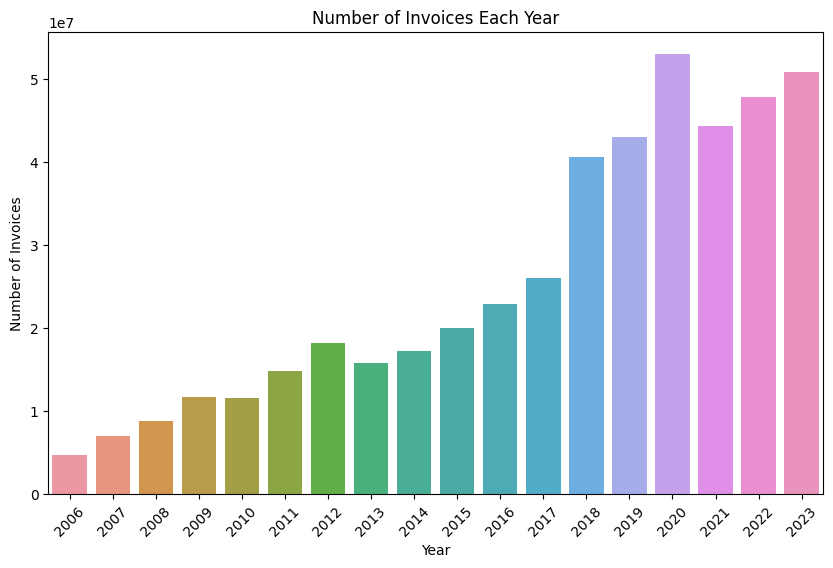

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=invoice_count_df.YEAR_INVOICED, y=invoice_count_df.INVOICE_COUNT)
plt.title('Number of Invoices Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

### 2

In [ ]:
# Group by 'YEAR_INVOICED' and aggregate
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped.show(5)

---------------------------------------------------------------------------
|"YEAR_INVOICED"  |"TOTAL_COUNT"  |"COUNT_DIAS_COMP_LE_0"  |"PERCENTAGE"  |
---------------------------------------------------------------------------
|2007             |6989472        |2516684                 |36.006800     |
|2010             |11583623       |4486695                 |38.733100     |
|2013             |15755454       |6675058                 |42.366600     |
|2021             |44365033       |18905214                |42.612900     |
|2022             |47908312       |19684701                |41.088300     |
---------------------------------------------------------------------------



In [ ]:
grouped_OT_CR=grouped.to_pandas()

In [ ]:
grouped_OT_CR.head()

,YEAR_INVOICED,TOTAL_COUNT,COUNT_DIAS_COMP_LE_0,PERCENTAGE
0,2007,6989472,2516684,36.0068
1,2022,47908312,19684701,41.0883
2,2015,19999053,7871247,39.3581
3,2017,25972273,10130157,39.0037
4,2012,18240328,6872212,37.6759


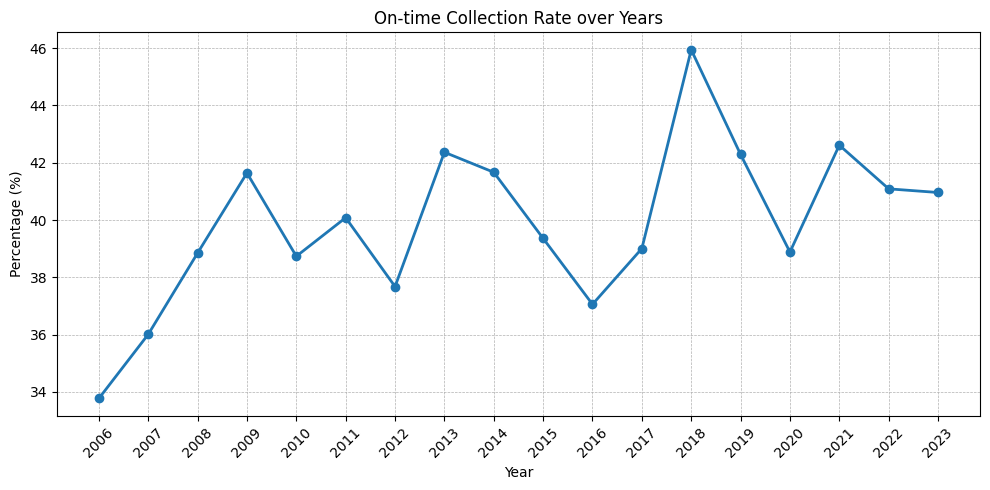

In [ ]:
grouped_OT_CR = grouped_OT_CR.sort_values('YEAR_INVOICED')
# Start the plot
plt.figure(figsize=(10, 5))
plt.plot(grouped_OT_CR['YEAR_INVOICED'], grouped_OT_CR['PERCENTAGE'], marker='o', linewidth=2)  # Added marker and line width

# Set the title and labels
plt.title('On-time Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

# Set x-ticks if 'YEAR_INVOICED' is not the index
plt.xticks(grouped_OT_CR['YEAR_INVOICED'].unique())

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

### 3

In [ ]:
# Group by 'YEAR_INVOICED' and aggregate
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"StatusCompensacion"') =='Pagada', 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_CR=grouped.to_pandas()

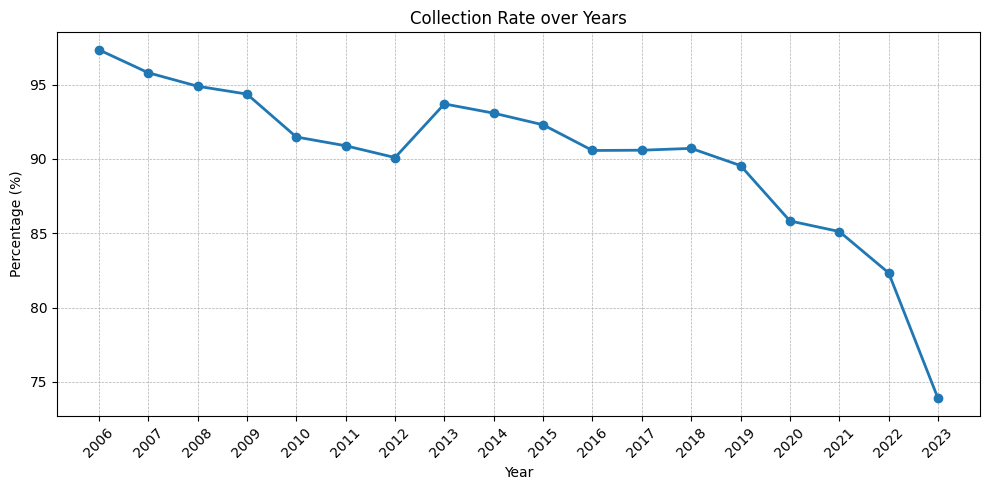

In [ ]:
grouped_OT_CR = grouped_CR.sort_values('YEAR_INVOICED')
# Start the plot
plt.figure(figsize=(10, 5))
plt.plot(grouped_OT_CR['YEAR_INVOICED'], grouped_OT_CR['PERCENTAGE'], marker='o', linewidth=2)  # Added marker and line width

# Set the title and labels
plt.title('Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

# Set x-ticks if 'YEAR_INVOICED' is not the index
plt.xticks(grouped_OT_CR['YEAR_INVOICED'].unique())

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

### 4

In [ ]:
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED'), col('"MaxCategoriaVehiculo"')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_VEH_OT=grouped.to_pandas()

In [ ]:
grouped_VEH_OT.head()

,YEAR_INVOICED,MaxCategoriaVehiculo,TOTAL_COUNT,COUNT_DIAS_COMP_LE_0,PERCENTAGE
0,2020,1.0,45813611,17605124,38.4277
1,2016,0.0,48794,11234,23.0233
2,2016,3.0,2050659,986876,48.1248
3,2013,0.0,23846,6422,26.9311
4,2007,2.0,961186,308824,32.1295


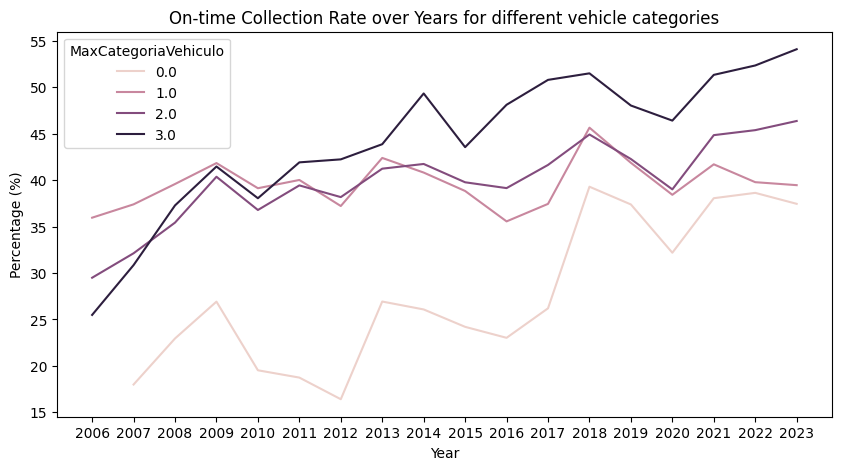

In [ ]:
# grouped.reset_index(inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped_VEH_OT, x='YEAR_INVOICED', y='PERCENTAGE',hue='MaxCategoriaVehiculo')

plt.title('On-time Collection Rate over Years for different vehicle categories')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped_VEH_OT['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

### 5

In [ ]:
from snowflake.snowpark.functions import col, median

df_pagada = df_con_equifax_v_dt.filter(col('"StatusCompensacion"') == 'Pagada')

grouped = df_pagada.groupBy(col('YEAR_INVOICED'), col('"MONTH_INVOICED"')).agg(
    median('"DiasCompensacion"').alias('median_dias_comp')
)
# To display or collect the result
grouped.show()

-----------------------------------------------------------
|"YEAR_INVOICED"  |"MONTH_INVOICED"  |"MEDIAN_DIAS_COMP"  |
-----------------------------------------------------------
|2013             |10                |2.0                 |
|2012             |4                 |5.0                 |
|2007             |5                 |10.0                |
|2023             |6                 |-2.0                |
|2020             |10                |3.0                 |
|2010             |2                 |12.0                |
|2011             |2                 |4.0                 |
|2023             |5                 |-1.0                |
|2013             |5                 |1.0                 |
|2022             |7                 |1.0                 |
-----------------------------------------------------------



In [ ]:
month_df=grouped.to_pandas()

In [ ]:
month_df.sort_values(['YEAR_INVOICED','MONTH_INVOICED'], inplace=True)

In [ ]:
month_df

,YEAR_INVOICED,MONTH_INVOICED,MEDIAN_DIAS_COMP
160,2006,1,24.0
67,2006,2,12.0
96,2006,3,12.0
197,2006,4,15.0
132,2006,5,11.0
...,...,...,...
47,2023,8,-1.0
50,2023,9,-2.0
12,2023,10,-4.0
161,2023,11,-2.0


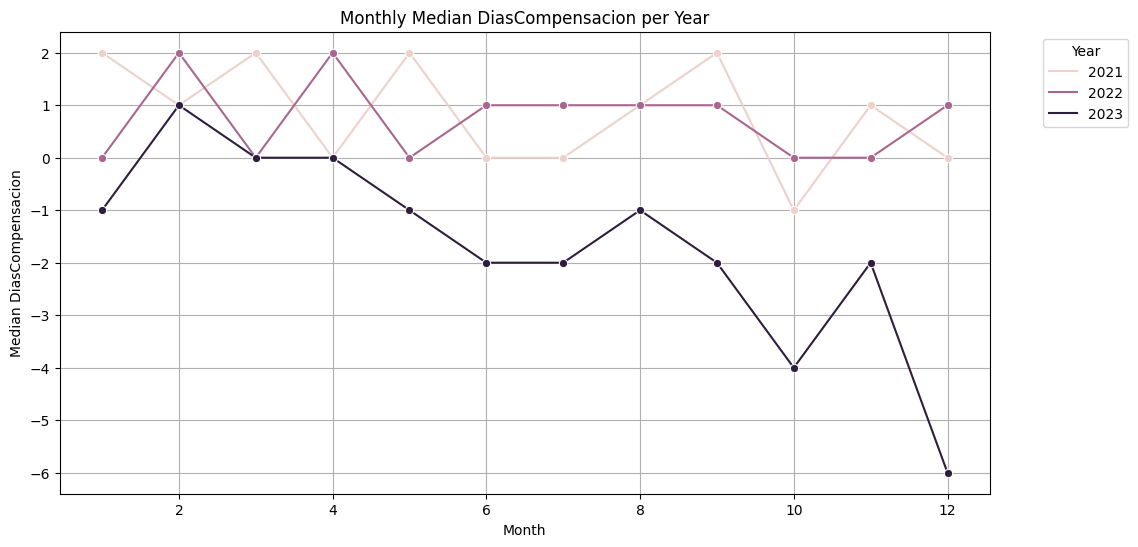

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=month_df[-36:], x='MONTH_INVOICED', y='MEDIAN_DIAS_COMP', hue='YEAR_INVOICED', marker='o')

plt.title('Monthly Median DiasCompensacion per Year')
plt.xlabel('Month')
plt.ylabel('Median DiasCompensacion')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.grid(True)
plt.show()

### 6

In [ ]:
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED'), col('"TipoCliente"')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_client_type=grouped.to_pandas()

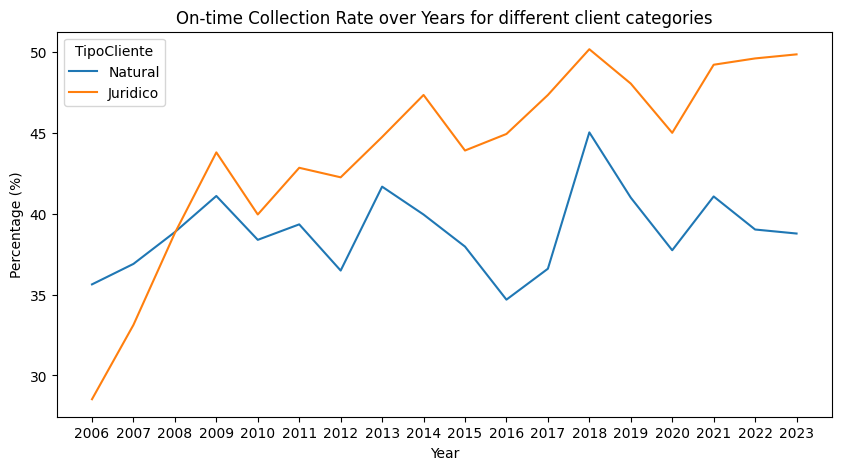

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped_client_type, x='YEAR_INVOICED', y='PERCENTAGE',hue='TipoCliente')

plt.title('On-time Collection Rate over Years for different client categories')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped_client_type['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

In [ ]:
total_rows = df_con_equifax_v_dt.count()

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_con_equifax_v_dt.groupBy('"TipoCliente"').agg(count("*").alias("count"))

count_distinct_types = count_distinct_types.withColumn('percentage', (col('count') / lit(total_rows)) * 100)

# Show the results
count_distinct_types.show()

--------------------------------------------
|"TipoCliente"  |"COUNT"    |"PERCENTAGE"  |
--------------------------------------------
|Natural        |366591931  |79.931600     |
|Juridico       |92040072   |20.068400     |
--------------------------------------------



#### Get 100k rows for further EDA and visualizations

## ONLY FOR SAMPLED DATA OF 100k

In [ ]:
# from snowflake.snowpark.functions import desc, asc
# df_con_equifax_v_dt = df_filtered.orderBy(asc('"YEAR_DUE"'))

In [ ]:
df_con_equifax_v_prep_pd = df_con_equifax_v_dt.limit(100000)
df_con_equifax_v_prep_pd = df_con_equifax_v_prep_pd.to_pandas()
# df_con_equifax_v_prep_pd.dtypes

In [ ]:
df_con_equifax_v_prep_pd .columns

Index(['FechaEmision', 'FechaVencimiento', 'PosicionDocumento', 'ImportePesos',
       'DocumentoCompensacion', 'FechaCompensacion', 'DiasCompensacion',
       'OperacionPrincipal', 'OperacionParcial', 'COMUNA', 'CIUDAD', 'REGION',
       'CantidadCuentasContrato', 'MaxCategoriaVehiculo', 'CantidadVehiculos',
       'TramoMoraCliente', 'TramoMora', 'Inhabilitado', 'Concesionaria',
       'TipoCliente', 'TipoOperacion', 'TipoDocumento', 'TipoProducto',
       'StatusCompensacion', 'Score Equifax', 'YEAR_DUE', 'MONTH_DUE',
       'YEAR_PAID', 'MONTH_PAID', 'YEAR_INVOICED', 'MONTH_INVOICED', 'UNPAID'],
      dtype='object')

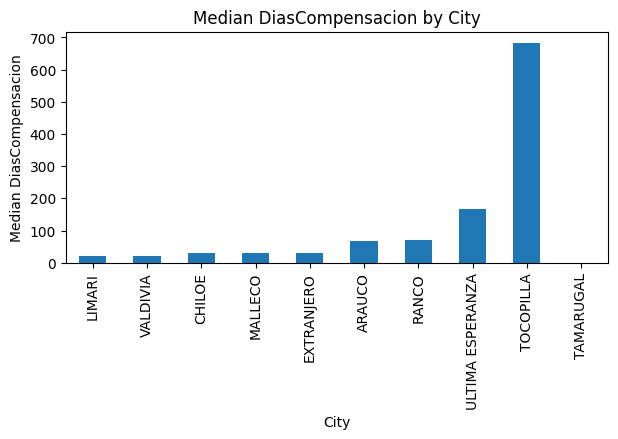

In [ ]:
city_medians = df_con_equifax_v_prep_pd.groupby('CIUDAD')['DiasCompensacion'].median().sort_values()[-10:]
city_medians.plot(x='City',kind='bar', figsize=(7, 3))
plt.title('Median DiasCompensacion by City')
plt.xlabel('City')
plt.ylabel('Median DiasCompensacion')
plt.show()

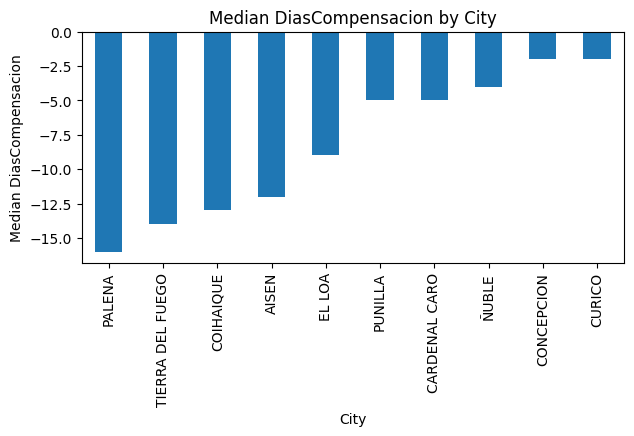

In [ ]:
city_medians = df_con_equifax_v_prep_pd.groupby('CIUDAD')['DiasCompensacion'].median().sort_values()[:10]
city_medians.plot(x='City',kind='bar', figsize=(7, 3))
plt.title('Median DiasCompensacion by City')
plt.xlabel('City')
plt.ylabel('Median DiasCompensacion')
plt.show()

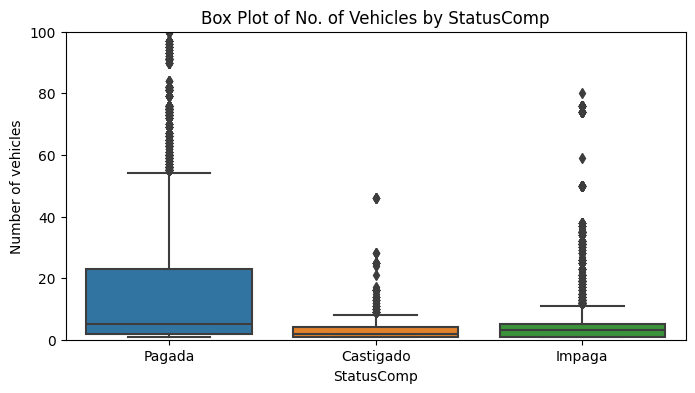

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='StatusCompensacion', y='CantidadVehiculos', data=df_con_equifax_v_prep_pd)
plt.title('Box Plot of No. of Vehicles by StatusComp')
plt.xlabel('StatusComp')
plt.ylabel('Number of vehicles')
plt.ylim(0,100)
plt.show()

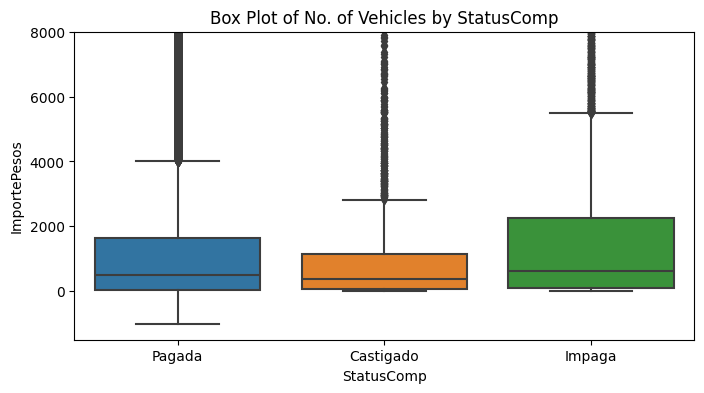

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='StatusCompensacion', y='ImportePesos', data=df_con_equifax_v_prep_pd)
plt.title('Box Plot of No. of Vehicles by StatusComp')
plt.xlabel('StatusComp')
plt.ylabel('ImportePesos')
plt.ylim(-1500,8000)
plt.show()

In [ ]:
df_con_equifax_v_prep_pd.head(30)


,FechaEmision,FechaVencimiento,PosicionDocumento,ImportePesos,DocumentoCompensacion,FechaCompensacion,DiasCompensacion,OperacionPrincipal,OperacionParcial,COMUNA,...,TipoProducto,StatusCompensacion,Score Equifax,YEAR_DUE,MONTH_DUE,YEAR_PAID,MONTH_PAID,YEAR_INVOICED,MONTH_INVOICED,UNPAID
0,2014-05-29,2014-06-13,1000.0,4593.0,1.080270e+08,2016-12-31,932.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2014,6,2016.0,12.0,2014,5,0
1,2014-05-29,2014-06-13,2000.0,1059.0,1.080270e+08,2016-12-31,932.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2014,6,2016.0,12.0,2014,5,0
2,2014-01-29,2014-02-13,1000.0,3.0,1.080270e+08,2016-12-31,1052.0,0040,0025,PUENTE ALTO,...,Tag,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0
3,2014-01-29,2014-02-13,2000.0,53.0,1.080270e+08,2016-12-31,1052.0,0040,0020,PUENTE ALTO,...,Tag,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0
4,2014-01-29,2014-02-13,3000.0,8.0,1.080270e+08,2016-12-31,1052.0,0040,0020,PUENTE ALTO,...,Tag,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0
5,2022-04-26,2022-05-11,1000.0,100.0,0.000000e+00,None,NaN,0040,0020,PUENTE ALTO,...,Tag,Impaga,61.0,2022,5,NaN,NaN,2022,4,1
6,2014-07-31,2014-08-18,2000.0,2228.0,1.080270e+08,2016-12-31,866.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2014,8,2016.0,12.0,2014,7,0
7,2014-07-31,2014-08-18,1000.0,2555.0,1.080270e+08,2016-12-31,866.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2014,8,2016.0,12.0,2014,7,0
8,2015-01-30,2015-02-16,1000.0,960.0,1.080270e+08,2016-12-31,684.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2015,2,2016.0,12.0,2015,1,0
9,2015-01-30,2015-02-16,2000.0,780.0,1.080270e+08,2016-12-31,684.0,0100,0002,PUENTE ALTO,...,Tag,Castigado,61.0,2015,2,2016.0,12.0,2015,1,0


In [ ]:
df_con_equifax_v_prep_pd['YEAR_DUE'].unique()

array([2014, 2022, 2015, 2016, 2023, 2010, 2020, 2009, 2012, 2007, 2019,
       2021, 2008, 2011, 2018, 2013, 2024, 2006, 2017], dtype=int16)

In [ ]:
df_con_equifax_v_prep_pd['YEAR_PAID'].unique()

array([2016.,   nan, 2022., 2023., 2010., 2014., 2020., 2009., 2012.,
       2007., 2011., 2019., 2021., 2008., 2018., 2013., 2006., 2017.,
       2015., 2024.])

In [ ]:
df_con_equifax_v_prep_pd['YEAR_INVOICED'].unique()

array([2014, 2022, 2015, 2013, 2016, 2023, 2010, 2020, 2009, 2012, 2007,
       2019, 2021, 2008, 2011, 2018, 2006, 2017], dtype=int16)

### Univariate Analysis

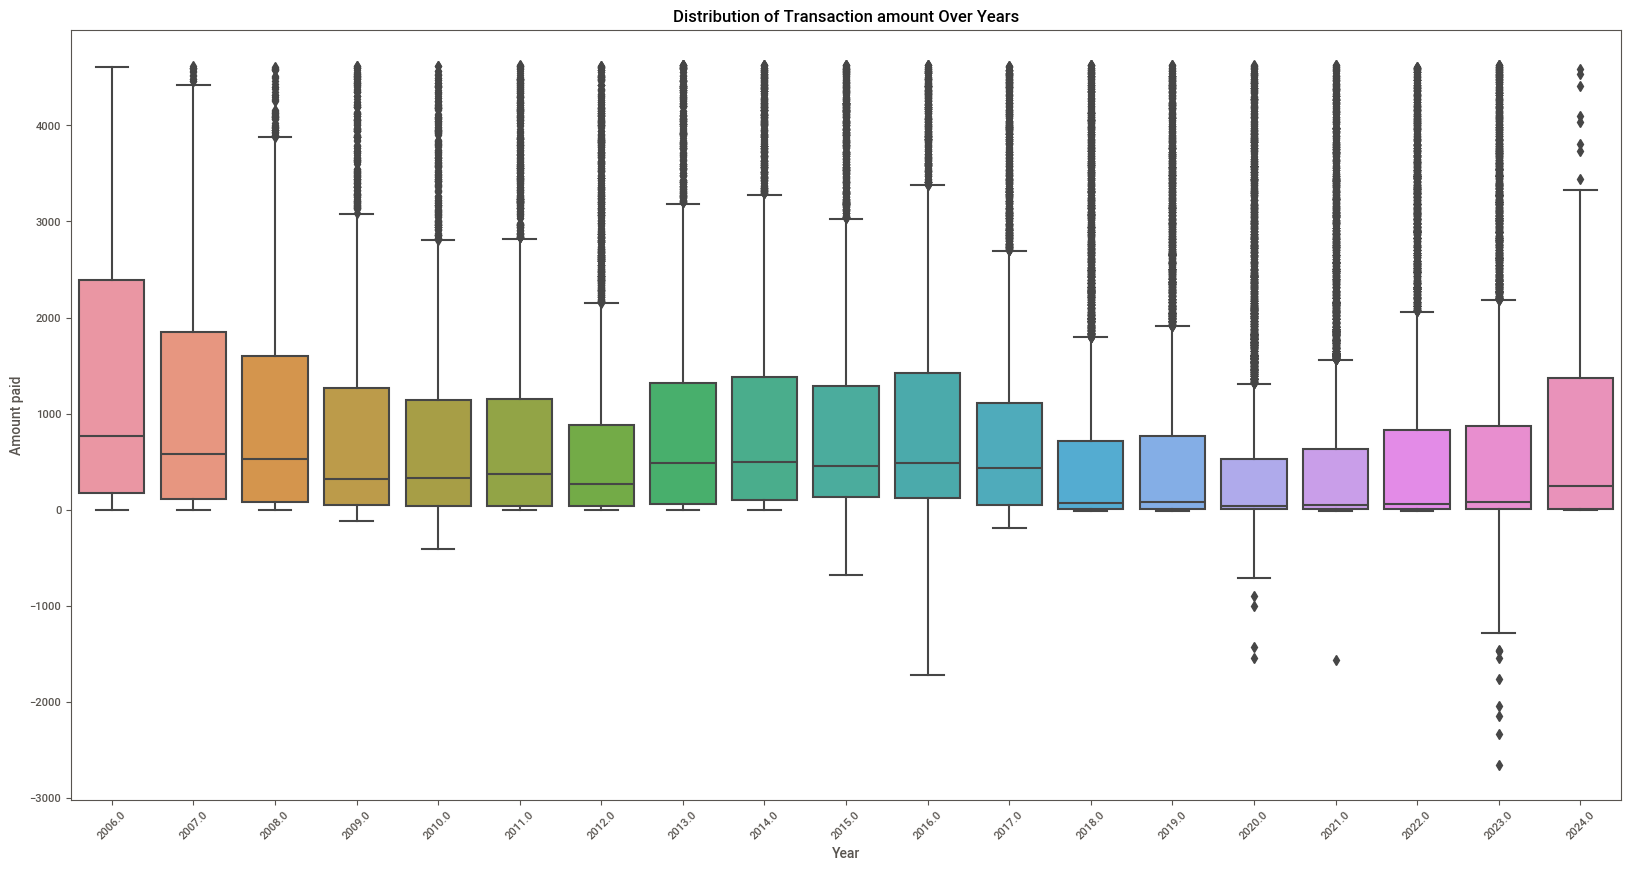

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))  # Width, height in inches
sns.boxplot(x='YEAR_PAID', y='ImportePesos', data=df_con_equifax_v_prep_pd)
plt.title('Distribution of Transaction amount Over Years')
plt.xlabel('Year')
plt.ylabel('Amount paid')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.show()

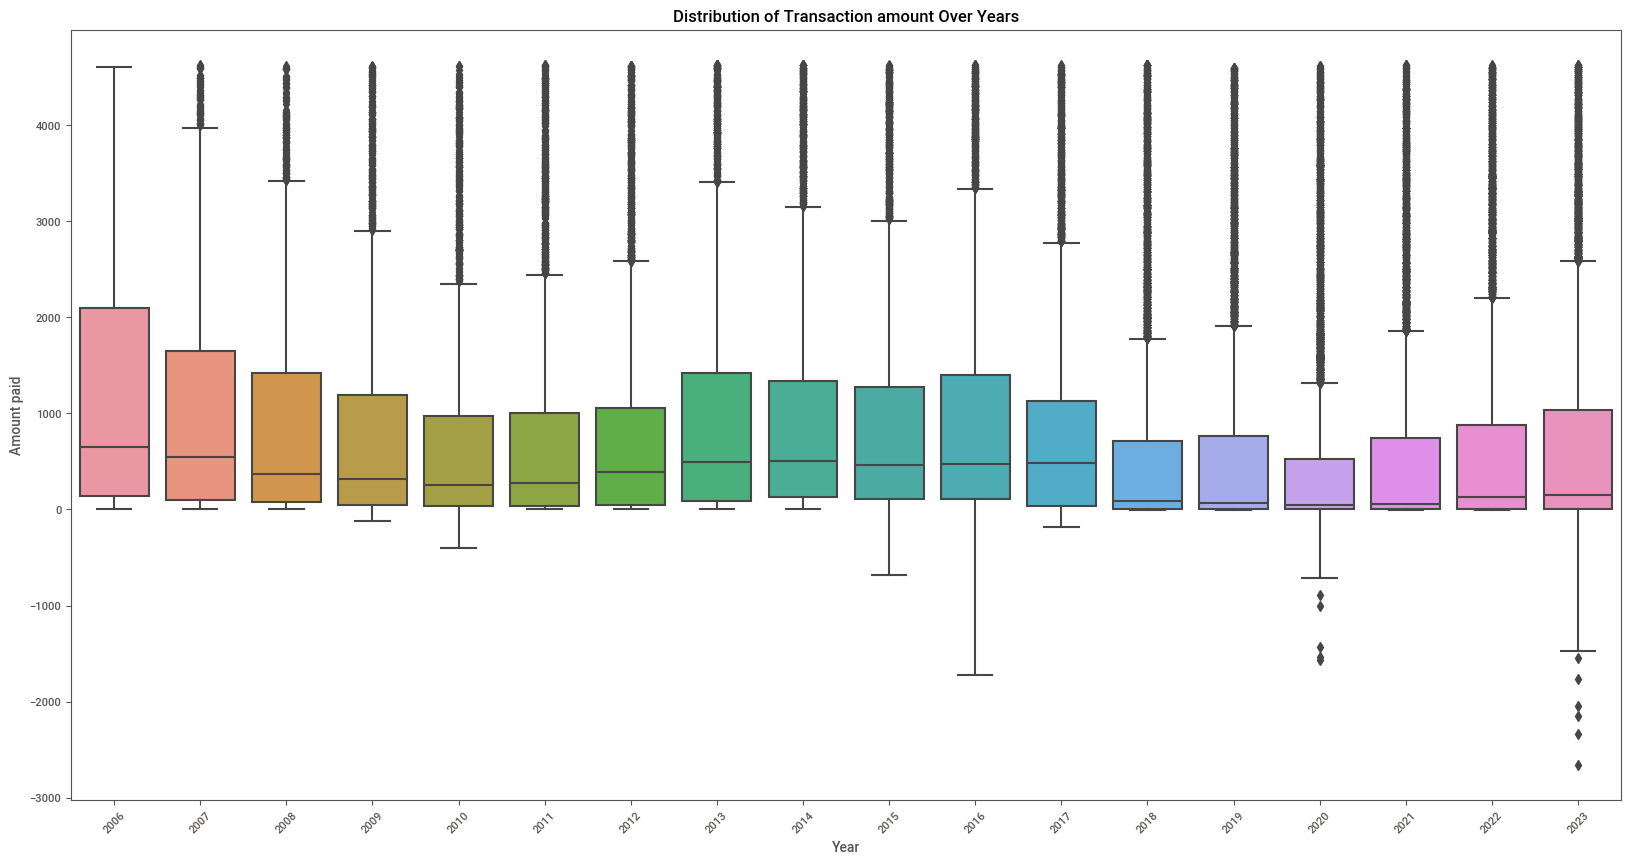

In [ ]:
plt.figure(figsize=(20, 10))  # Width, height in inches
sns.boxplot(x='YEAR_INVOICED', y='ImportePesos', data=df_con_equifax_v_prep_pd)
plt.title('Distribution of Transaction amount Over Years')
plt.xlabel('Year')
plt.ylabel('Amount paid')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.show()

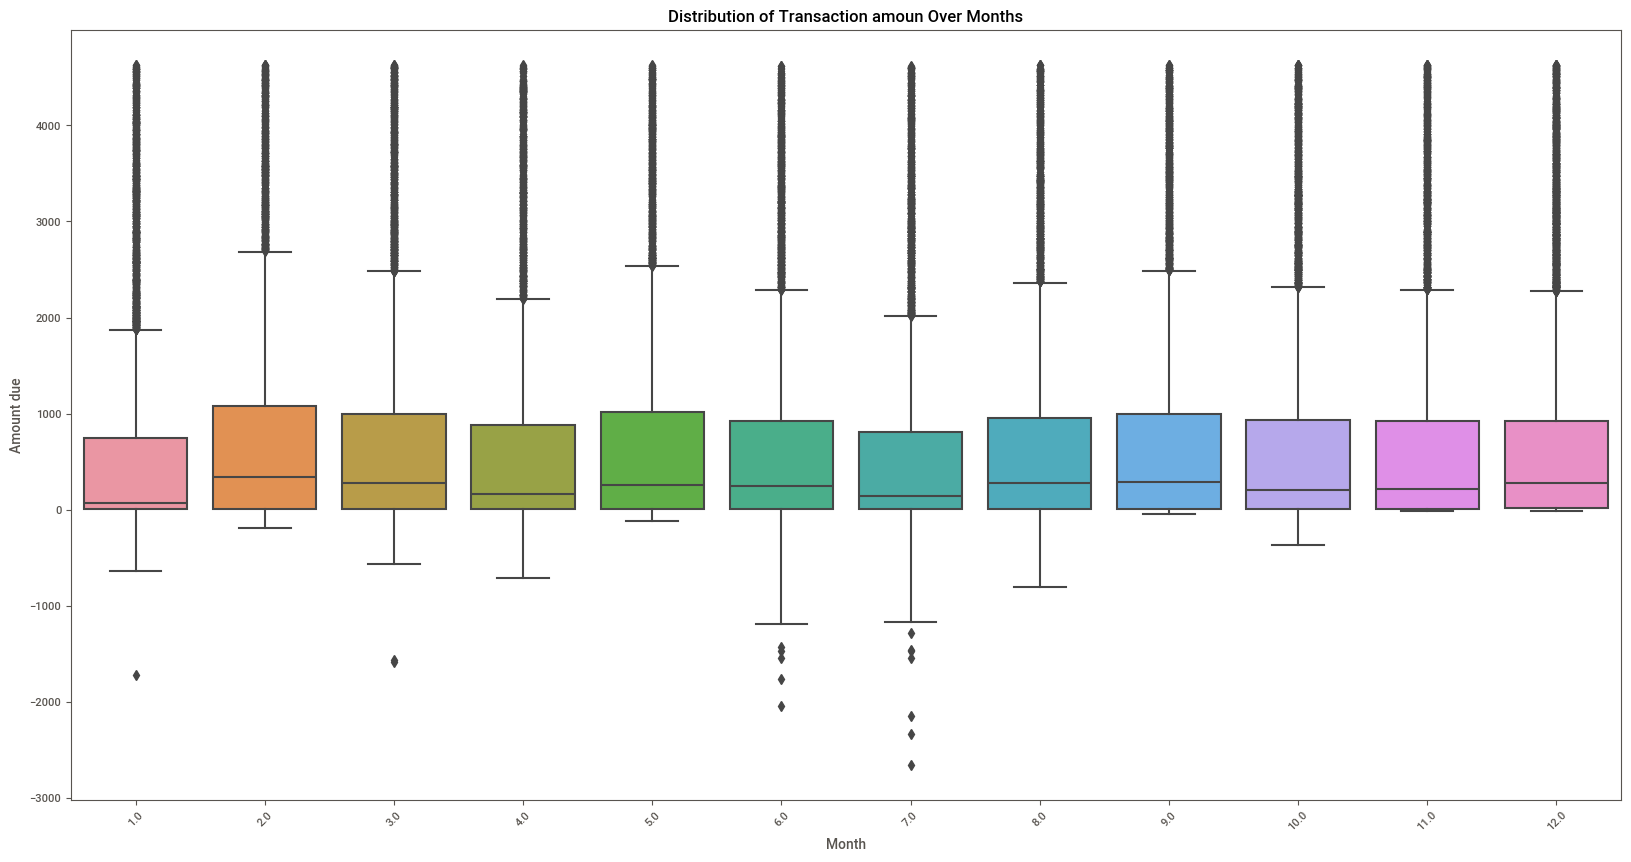

In [ ]:
plt.figure(figsize=(20, 10))  # Width, height in inches
sns.boxplot(x='MONTH_PAID', y='ImportePesos', data=df_con_equifax_v_prep_pd)
plt.title('Distribution of Transaction amoun Over Months')
plt.xlabel('Month')
plt.ylabel('Amount due')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.show()

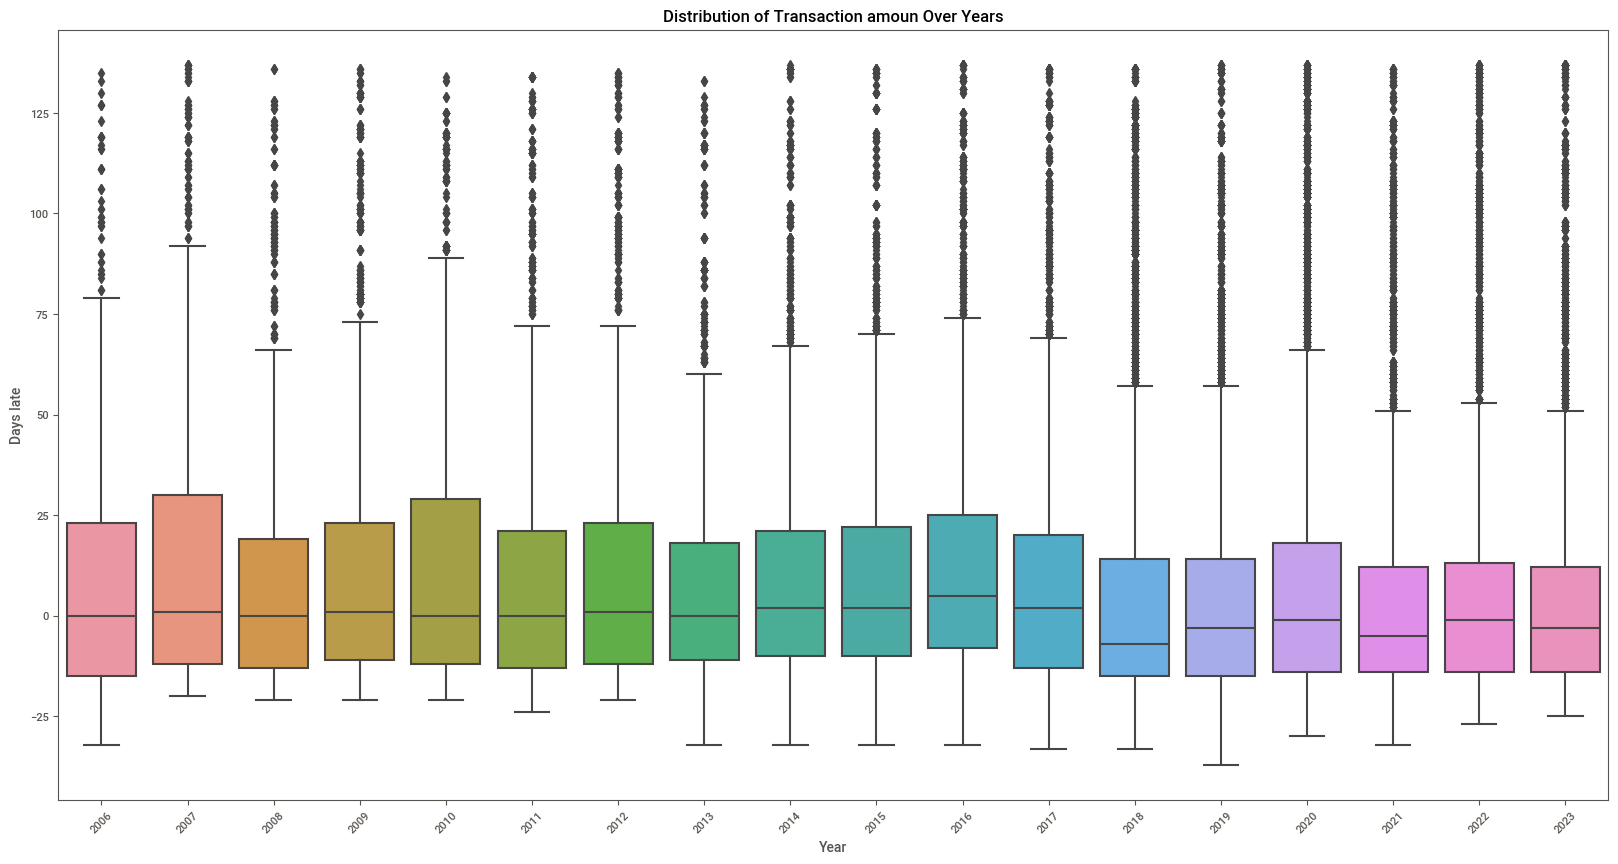

In [ ]:
Q1 = df_con_equifax_v_prep_pd['DiasCompensacion'].quantile(0.25)
Q3 = df_con_equifax_v_prep_pd['DiasCompensacion'].quantile(0.75)

# Step 2: Calculate the IQR
IQR = Q3 - Q1

# Step 3: Determine the Outlier Thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Filter Out Outliers
df_clean = df_con_equifax_v_prep_pd[(df_con_equifax_v_prep_pd['DiasCompensacion'] >= lower_bound) & (df_con_equifax_v_prep_pd['DiasCompensacion'] <= upper_bound)]
plt.figure(figsize=(20, 10))  # Width, height in inches
sns.boxplot(x='YEAR_INVOICED', y='DiasCompensacion', data=df_clean)
plt.title('Distribution of Transaction amoun Over Years')
plt.xlabel('Year')
plt.ylabel('Days late')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.show()

In [ ]:
# # # Filter the DataFrame for rows where 'dias_comp' is <= 0
# filtered_df = df_con_equifax_v_prep_pd[df_con_equifax_v_prep_pd['DiasCompensacion'] <= 0]

# # Group by 'month_invoiced' and count the occurrences
# grouped_df = filtered_df.groupby(['YEAR_INVOICED']).size()


# # Reset the index to make 'year' and 'month' columns for plotting
# # grouped_df = grouped_df.reset_index(name='count')

# # Plot the results
# # plt.figure(figsize=(15, 6))  # Adjust the size as needed
# # plt.bar(grouped_df['YEAR_INVOICED'].astype(str) + '-' + grouped_df['MONTH_INVOICED'].astype(str), grouped_df['count'])
# # plt.title('Count of dias_comp <= 0 by Year and Month')
# # plt.xlabel('Year-Month')
# # plt.xticks(rotation=45)  # Rotate labels for better readability
# # plt.ylabel('Count')
# # plt.tight_layout()  # Adjusts subplot params for better layout
# # plt.show()

# #Plot the results
# grouped_df.plot(kind='line')
# plt.title('Count of Timely payments')
# plt.xlabel('Month Invoiced')
# plt.ylabel('Count')
# plt.show()

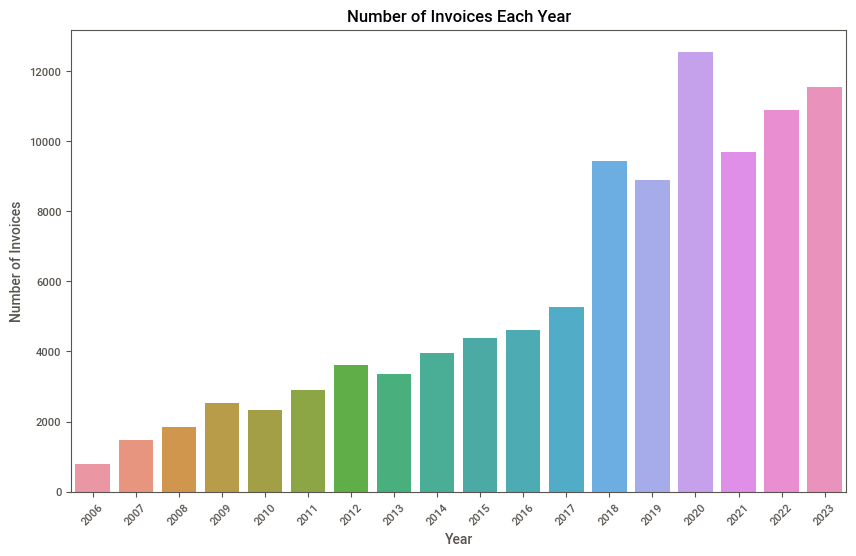

In [ ]:
# Count the number of invoices each year
invoice_count = df_con_equifax_v_prep_pd['YEAR_INVOICED'].value_counts().sort_index()

# Using Seaborn (Optional for a more elegant look)
plt.figure(figsize=(10, 6))
sns.barplot(x=invoice_count.index, y=invoice_count.values)
plt.title('Number of Invoices Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()


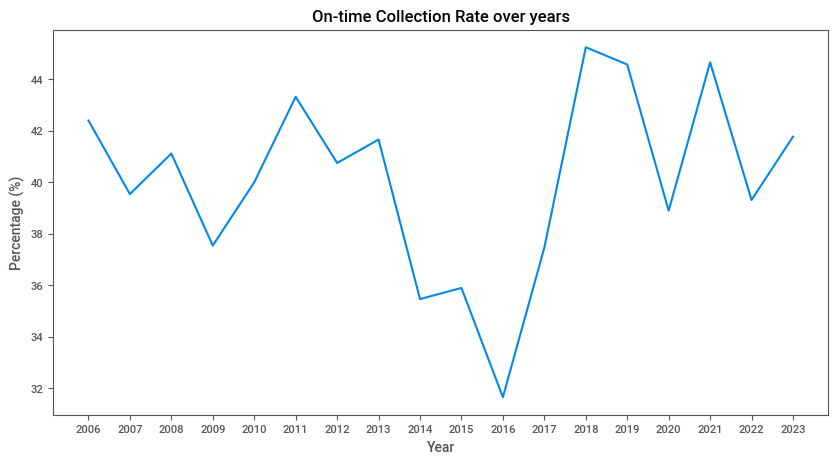

In [ ]:
df_con_equifax_v_prep_pd['YEAR_INVOICED'] = df_con_equifax_v_prep_pd['YEAR_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby(['YEAR_INVOICED']).agg(
    total_count=pd.NamedAgg(column='DiasCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='DiasCompensacion', aggfunc=lambda x: (x <= 0).sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100

#Plot the results
plt.figure(figsize=(10, 5))
grouped['percentage'].plot(kind='line')
plt.title('On-time Collection Rate over years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped.index.unique())
plt.show()

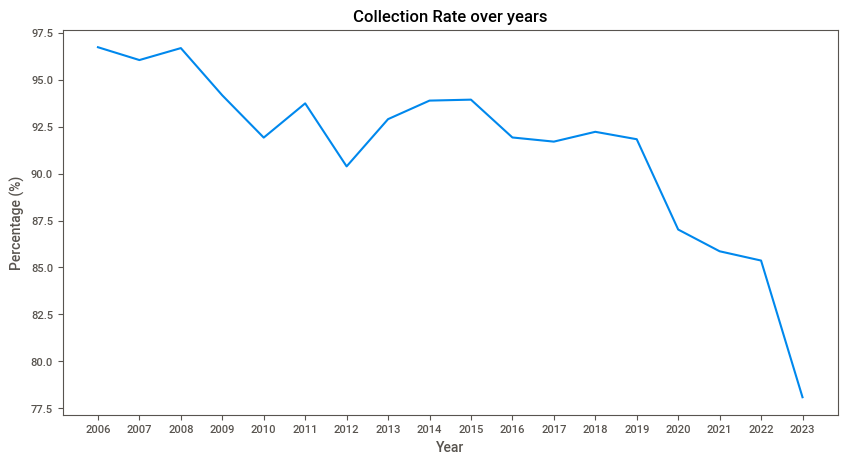

In [ ]:
df_con_equifax_v_prep_pd['YEAR_INVOICED'] = df_con_equifax_v_prep_pd['YEAR_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby(['YEAR_INVOICED']).agg(
    total_count=pd.NamedAgg(column='StatusCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='StatusCompensacion', aggfunc=lambda x: (x == 'Pagada').sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100

#Plot the results
plt.figure(figsize=(10, 5))
grouped['percentage'].plot(kind='line')
plt.title('Collection Rate over years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped.index.unique())
plt.show()

In [ ]:
df_con_equifax_v_prep_pd['YEAR_INVOICED'] = df_con_equifax_v_prep_pd['YEAR_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby(['YEAR_INVOICED','StatusCompensacion']).agg(
    total_count=pd.NamedAgg(column='DiasCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='DiasCompensacion', aggfunc=lambda x: (x <= 0).sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100

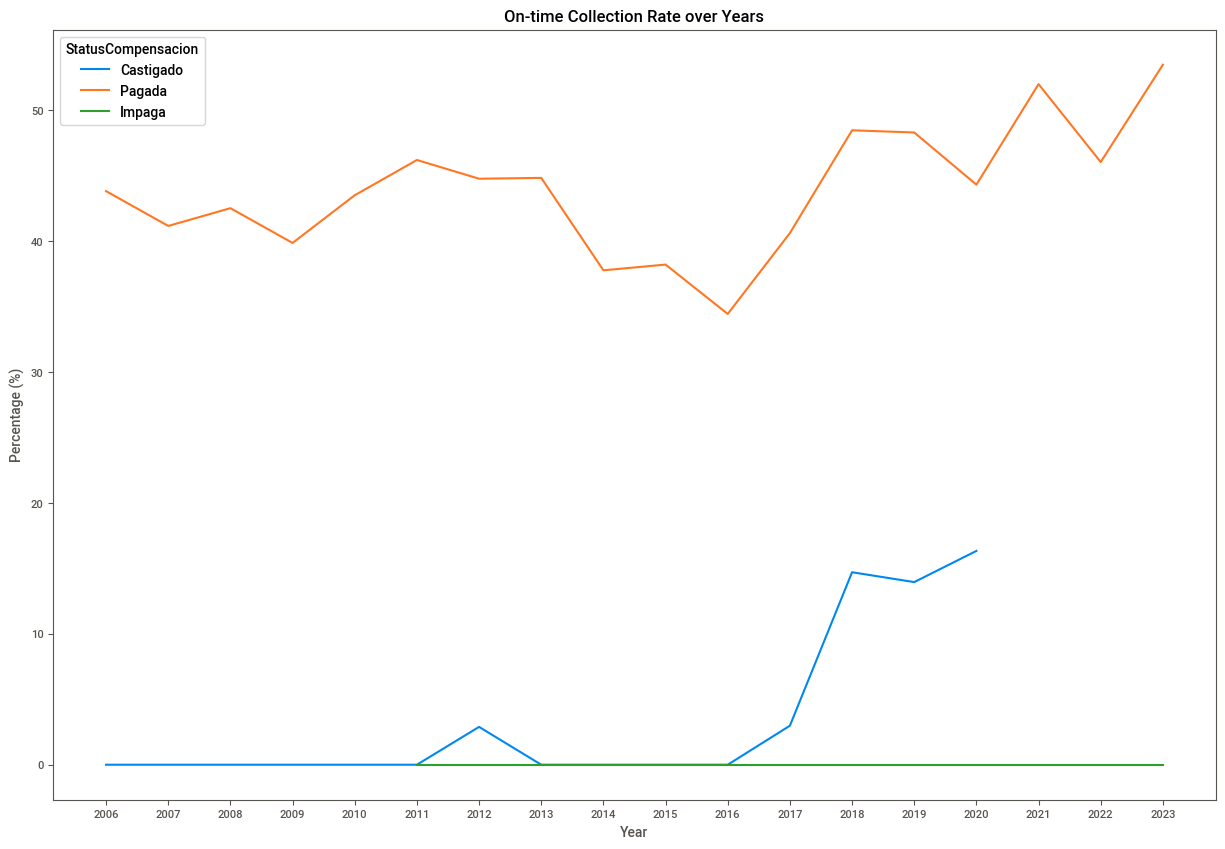

In [ ]:
grouped.reset_index(inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(15, 10))
sns.lineplot(data=grouped, x='YEAR_INVOICED', y='percentage',hue='StatusCompensacion')

plt.title('On-time Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

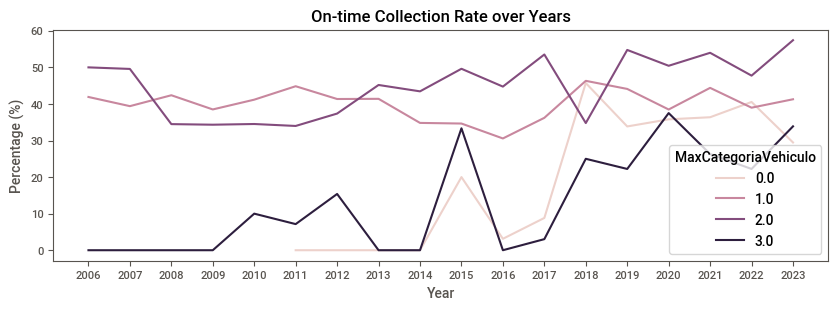

In [ ]:
df_con_equifax_v_prep_pd['YEAR_INVOICED'] = df_con_equifax_v_prep_pd['YEAR_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby(['YEAR_INVOICED','MaxCategoriaVehiculo']).agg(
    total_count=pd.NamedAgg(column='DiasCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='DiasCompensacion', aggfunc=lambda x: (x <= 0).sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100
grouped.reset_index(inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 3))
sns.lineplot(data=grouped, x='YEAR_INVOICED', y='percentage',hue='MaxCategoriaVehiculo')

plt.title('On-time Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

In [ ]:
df_con_equifax_v_prep_pd

,FechaEmision,FechaVencimiento,PosicionDocumento,ImportePesos,DocumentoCompensacion,FechaCompensacion,DiasCompensacion,OperacionPrincipal,OperacionParcial,COMUNA,...,StatusCompensacion,Score Equifax,YEAR_DUE,MONTH_DUE,YEAR_PAID,MONTH_PAID,YEAR_INVOICED,MONTH_INVOICED,UNPAID,City
0,2014-05-29,2014-06-13,1000.0,4593.0,1.080270e+08,2016-12-31,932.0,0100,0002,PUENTE ALTO,...,Castigado,61.0,2014,6,2016.0,12.0,2014,5,0,2014
1,2014-05-29,2014-06-13,2000.0,1059.0,1.080270e+08,2016-12-31,932.0,0100,0002,PUENTE ALTO,...,Castigado,61.0,2014,6,2016.0,12.0,2014,5,0,2014
2,2014-01-29,2014-02-13,1000.0,3.0,1.080270e+08,2016-12-31,1052.0,0040,0025,PUENTE ALTO,...,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0,2014
3,2014-01-29,2014-02-13,2000.0,53.0,1.080270e+08,2016-12-31,1052.0,0040,0020,PUENTE ALTO,...,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0,2014
4,2014-01-29,2014-02-13,3000.0,8.0,1.080270e+08,2016-12-31,1052.0,0040,0020,PUENTE ALTO,...,Castigado,61.0,2014,2,2016.0,12.0,2014,1,0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2022-07-14,2022-07-29,2000.0,1590.0,4.000043e+11,2022-09-01,34.0,0100,0002,PROVIDENCIA,...,Pagada,265.0,2022,7,2022.0,9.0,2022,7,0,2022
99996,2022-07-14,2022-07-29,3000.0,579.0,4.000043e+11,2022-09-01,34.0,0100,0002,PROVIDENCIA,...,Pagada,265.0,2022,7,2022.0,9.0,2022,7,0,2022
99997,2022-07-14,2022-07-29,4000.0,578.0,4.000043e+11,2022-09-01,34.0,0100,0002,PROVIDENCIA,...,Pagada,265.0,2022,7,2022.0,9.0,2022,7,0,2022
99998,2022-07-14,2022-07-29,5000.0,-5.0,3.170109e+09,2022-07-15,-14.0,RUND,RUND,PROVIDENCIA,...,Pagada,265.0,2022,7,2022.0,7.0,2022,7,0,2022


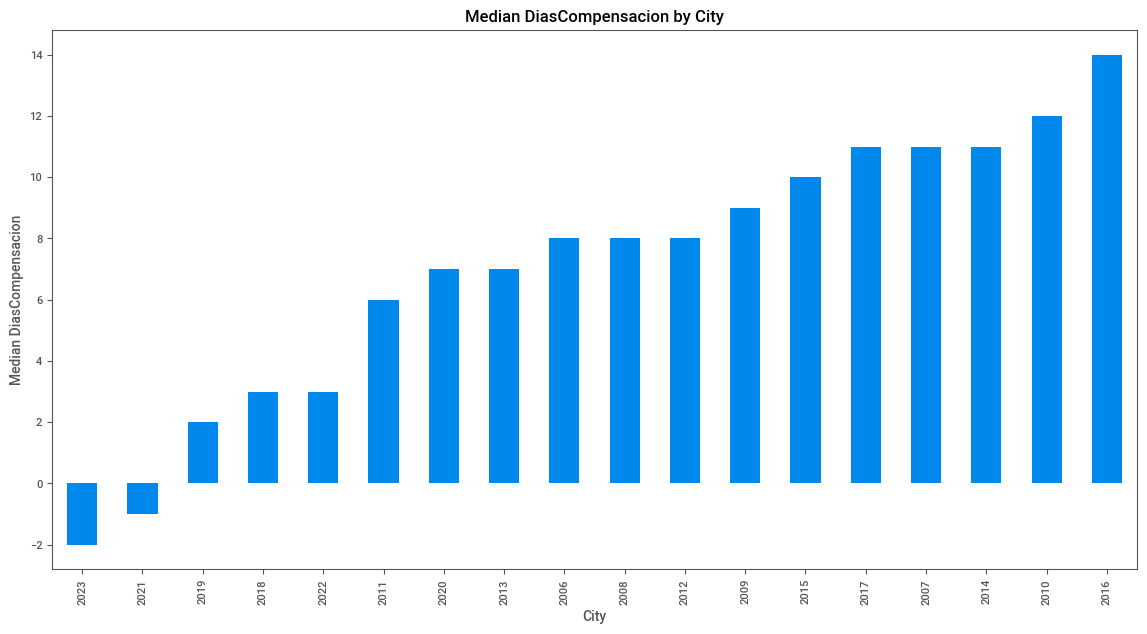

In [ ]:
# For median
city_medians = df_con_equifax_v_prep_pd.groupby('CUIDAD')['DiasCompensacion'].median().sort_values()
city_medians.plot(x='City',kind='bar', figsize=(14, 7))
plt.title('Median DiasCompensacion by City')
plt.xlabel('City')
plt.ylabel('Median DiasCompensacion')
plt.show()


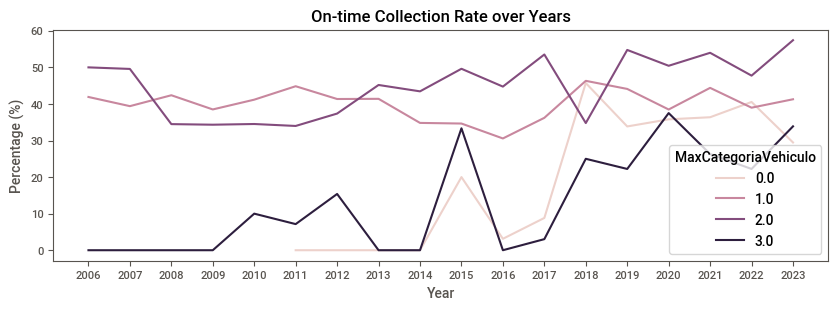

In [ ]:
df_con_equifax_v_prep_pd['City'] = df_con_equifax_v_prep_pd['YEAR_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby(['YEAR_INVOICED','MaxCategoriaVehiculo']).agg(
    total_count=pd.NamedAgg(column='DiasCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='DiasCompensacion', aggfunc=lambda x: (x <= 0).sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100
grouped.reset_index(inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 3))
sns.lineplot(data=grouped, x='YEAR_INVOICED', y='percentage',hue='MaxCategoriaVehiculo')

plt.title('On-time Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

In [ ]:
df_con_equifax_v_prep_pd[df_con_equifax_v_prep_pd['MaxCategoriaVehiculo']==0]

,FechaEmision,FechaVencimiento,PosicionDocumento,ImportePesos,DocumentoCompensacion,FechaCompensacion,DiasCompensacion,OperacionPrincipal,OperacionParcial,COMUNA,...,StatusCompensacion,Score Equifax,YEAR_DUE,MONTH_DUE,YEAR_PAID,MONTH_PAID,YEAR_INVOICED,MONTH_INVOICED,UNPAID,City
2838,2020-03-04,2020-03-19,2000.0,2690.0,3.009618e+11,2020-06-22,95.0,0100,0002,CONCHALI,...,Pagada,864.0,2020,3,2020.0,6.0,2020,3,0,2020
2839,2020-03-04,2020-03-19,2001.0,3.0,3.260039e+09,2020-03-04,-15.0,0100,0002,CONCHALI,...,Pagada,864.0,2020,3,2020.0,3.0,2020,3,0,2020
2840,2020-03-04,2020-03-19,3000.0,-3.0,3.260039e+09,2020-03-04,-15.0,RUND,RUND,CONCHALI,...,Pagada,864.0,2020,3,2020.0,3.0,2020,3,0,2020
3006,2016-06-06,2016-06-21,2000.0,336.0,7.760095e+09,2016-06-06,-15.0,0100,0002,CONCHALI,...,Pagada,864.0,2016,6,2016.0,6.0,2016,6,0,2016
3386,2015-05-05,2015-05-20,2000.0,272.0,7.720086e+09,2015-05-07,-13.0,0100,0002,CONCHALI,...,Pagada,864.0,2015,5,2015.0,5.0,2015,5,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99738,2022-07-08,2022-07-25,1002.0,4.0,3.230189e+09,2023-01-09,168.0,0100,0002,SAN JOAQUIN,...,Pagada,593.0,2022,7,2023.0,1.0,2022,7,0,2022
99739,2023-10-05,2023-10-20,1000.0,3278.0,0.000000e+00,None,NaN,0100,0002,SAN JOAQUIN,...,Impaga,593.0,2023,10,NaN,NaN,2023,10,1,2023
99740,2023-10-05,2023-10-20,2000.0,-8.0,8.970189e+09,2023-10-06,-14.0,RUND,RUND,SAN JOAQUIN,...,Pagada,593.0,2023,10,2023.0,10.0,2023,10,0,2023
99741,2023-01-07,2023-01-23,1000.0,3547.0,0.000000e+00,None,NaN,0100,0002,SAN JOAQUIN,...,Impaga,593.0,2023,1,NaN,NaN,2023,1,1,2023


In [ ]:
df_con_equifax_v_prep_pd['TipoCliente'].unique()

array(['Natural'], dtype=object)

In [ ]:
# plt.figure(figsize=(10, 6))  # Adjust the size as needed
# sns.lineplot(data=grouped, x='YEAR_INVOICED', y='DiasCompensacion', hue='TipoCliente')

# plt.title('Average dias_comp by Year for Different Client Types')
# plt.xlabel('Year')
# plt.ylabel('Average dias_comp')
# plt.xticks(df_con_equifax_v_prep_pd['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
# plt.legend(title='Client Type')  # Customize the legend
# plt.grid(True)  # Optional for better readability
# plt.show()

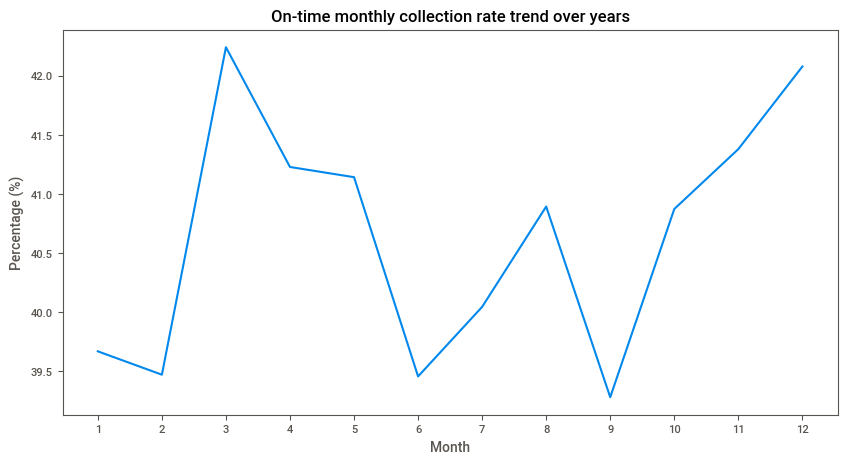

In [ ]:
df_con_equifax_v_prep_pd['MONTH_INVOICED'] = df_con_equifax_v_prep_pd['MONTH_INVOICED'].astype(int)
grouped = df_con_equifax_v_prep_pd.groupby('MONTH_INVOICED').agg(
    total_count=pd.NamedAgg(column='DiasCompensacion', aggfunc='size'),
    count_dias_comp_le_0=pd.NamedAgg(column='DiasCompensacion', aggfunc=lambda x: (x <= 0).sum())
)

# Calculate the percentage
grouped['percentage'] = (grouped['count_dias_comp_le_0'] / grouped['total_count']) * 100

# Plot the results
plt.figure(figsize=(10, 5))
grouped['percentage'].plot(kind='line')
plt.title('On-time monthly collection rate trend over years')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(grouped.index.unique())
plt.show()

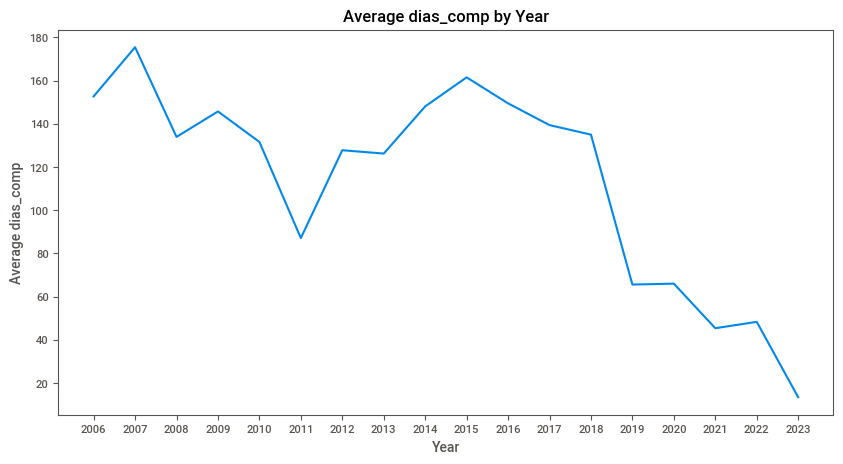

In [ ]:
grouped = df_con_equifax_v_prep_pd.groupby('YEAR_INVOICED')['DiasCompensacion'].mean()

# Plot the results as a line chart
plt.figure(figsize=(10, 5))
grouped.plot(kind='line')
plt.title('Average dias_comp by Year')
plt.xlabel('Year')
plt.ylabel('Average dias_comp')
plt.xticks(grouped.index.unique())  # Set x-ticks to the unique years
plt.grid(False)  # Optional for better readability
plt.show()

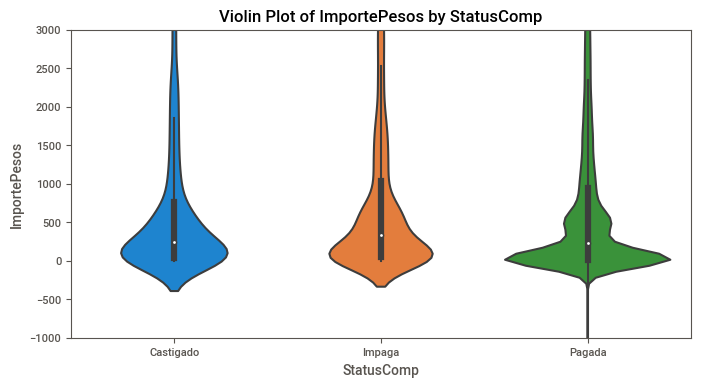

In [ ]:
plt.figure(figsize=(8, 4))
sns.violinplot(x='StatusCompensacion', y='ImportePesos', data=df_con_equifax_v_prep_pd)
plt.title('Violin Plot of ImportePesos by StatusComp')
plt.xlabel('StatusComp')
plt.ylabel('ImportePesos')
plt.ylim(-1000,3000)
plt.show()

In [ ]:
medians = df_con_equifax_v_prep_pd.groupby('StatusCompensacion')['ImportePesos'].median()

# Display the median values
print(medians)

StatusCompensacion
Castigado    238.0
Impaga       332.0
Pagada       228.0
Name: ImportePesos, dtype: float64


In [ ]:
# plt.figure(figsize=(20, 40))  # Width, height in inches
# sns.boxplot(x='YEAR_DUE', y='DiasCompensacion', data=df_con_equifax_v_prep_pd)
# plt.title('Distribution of Day Differences Over Years')
# plt.xlabel('Year')
# plt.ylabel('Amount due')
# plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
# plt.show()

In [ ]:
# import sweetviz as sv
# report = sv.analyze(df_con_equifax_v_prep_pd)
# report.show_html()

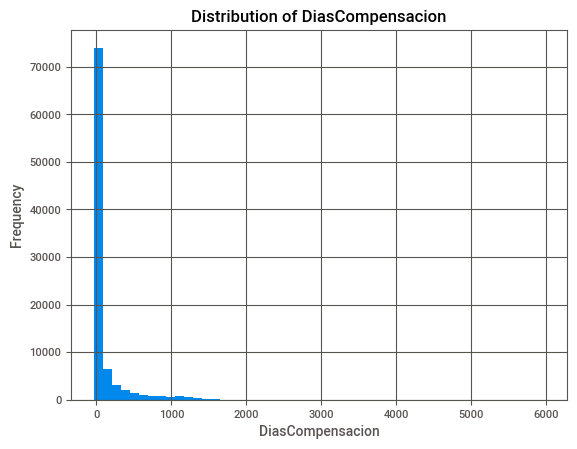

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ImportePesos' is correctly formatted as a numeric column
df_con_equifax_v_prep_pd['DiasCompensacion'].hist(bins=50)
plt.title('Distribution of DiasCompensacion')
plt.xlabel('DiasCompensacion')
plt.ylabel('Frequency')
plt.show()

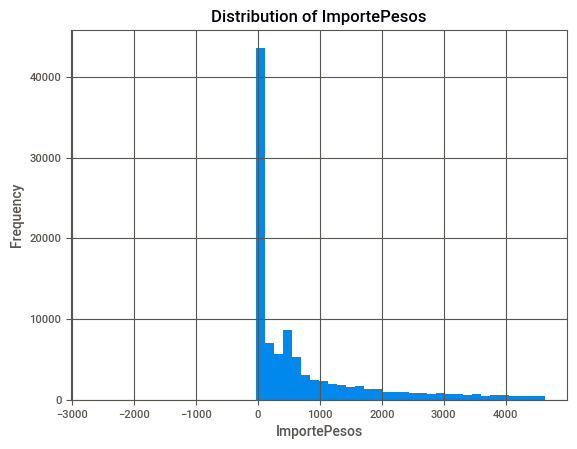

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ImportePesos' is correctly formatted as a numeric column
df_con_equifax_v_prep_pd['ImportePesos'].hist(bins=50)
plt.title('Distribution of ImportePesos')
plt.xlabel('ImportePesos')
plt.ylabel('Frequency')
plt.show()

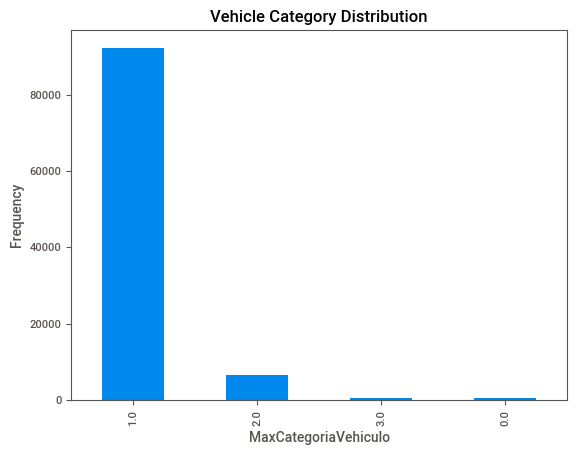

In [ ]:
# Assuming 'MaxCategoriaVehiculo' is a categorical column
df_con_equifax_v_prep_pd['MaxCategoriaVehiculo'].value_counts().plot(kind='bar')
plt.title('Vehicle Category Distribution')
plt.xlabel('MaxCategoriaVehiculo')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_con_equifax_v_prep_pd['MaxCategoriaVehiculo'].value_counts(normalize=True)

1.0    0.92299
2.0    0.06630
3.0    0.00593
0.0    0.00478
Name: MaxCategoriaVehiculo, dtype: float64

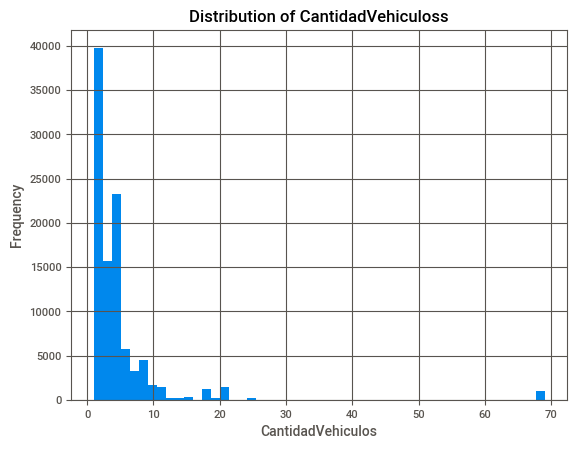

In [ ]:
df_con_equifax_v_prep_pd['CantidadVehiculos'].hist(bins=50)
plt.title('Distribution of CantidadVehiculoss')
plt.xlabel('CantidadVehiculos')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_con_equifax_v_prep_pd['CantidadVehiculos'].max()

69

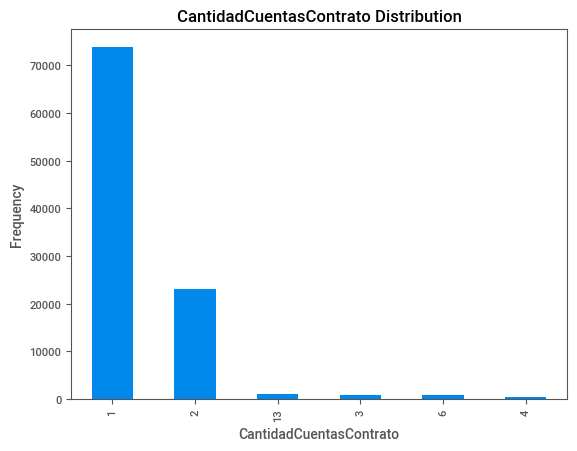

In [ ]:
df_con_equifax_v_prep_pd['CantidadCuentasContrato'].value_counts().plot(kind='bar')
plt.title('CantidadCuentasContrato Distribution')
plt.xlabel('CantidadCuentasContrato')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import sweetviz as sv
report = sv.analyze(df_con_equifax_v_prep_pd)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# categorical_columns = df_con_equifax_v_prep_pd.select_dtypes(include=['object','category']).columns.tolist()
# for col_cat in categorical_columns:
#     df_con_equifax_v_prep_pd[col_cat].value_counts().plot(kind='bar')
#     plt.title(f'{col_cat} Distribution')
#     plt.xlabel(f'{col_cat}')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# df_con_equifax_v_prep_pd['TipoCliente'].value_counts().plot(kind='bar')
# plt.title('TipoCliente Distribution')
# plt.xlabel('TipoCliente')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# df_con_equifax_v_prep_pd['TramoMoraCliente'].value_counts().plot(kind='bar')
# plt.title('TramoMoraCliente Distribution')
# plt.xlabel('TramoMoraCliente')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# df_con_equifax_v_prep_pd['TramoMora'].value_counts().plot(kind='bar')
# plt.title('TramoMora Distribution')
# plt.xlabel('TramoMora')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# df_con_equifax_v_prep_pd['Concesionaria'].value_counts().plot(kind='bar')
# plt.title('Concesionaria Distribution')
# plt.xlabel('Concesionaria')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# df_con_equifax_v_prep_pd['TipoOperacion'].value_counts().plot(kind='bar')
# plt.title('TipoOperacion Distribution')
# plt.xlabel('TipoOperacion')
# plt.ylabel('Frequency')
# plt.show()

#### Bivariate analysis

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.countplot(x='YEAR_PAID', hue='Unpaid', data=df_con_equifax_v_prep_pd)
# plt.title('Payments by Year')
# plt.xlabel('Year Paid')
# plt.ylabel('Count')
# plt.legend(title='Unpaid', loc='upper right', labels=['Paid', 'Unpaid'])
# plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
# plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.countplot(x='YEAR_DUE', hue='Unpaid', data=df_con_equifax_v_prep_pd)
# plt.title('Payments by Year')
# plt.xlabel('Year Paid')
# plt.ylabel('Count')
# plt.legend(title='Unpaid', loc='upper right', labels=['Paid', 'Unpaid'])
# plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
# plt.show()

In [ ]:
# # Creating a boxplot
# plt.figure(figsize=(20, 15))  # Width, height in inches
# sns.boxplot(x='YEAR_DUE', y='DiasCompensacion', data=df_con_equifax_v_prep_pd)
# plt.title('Distribution of Day Differences Over Years')
# plt.xlabel('Year')
# plt.ylabel('Day Difference')
# plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
# plt.show()


In [ ]:
# # Creating a boxplot
# plt.figure(figsize=(20, 40))  # Width, height in inches
# sns.boxplot(x='YEAR_DUE', y='ImportePesos', data=df_con_equifax_v_prep_pd)
# plt.title('Distribution of Day Differences Over Years')
# plt.xlabel('Year')
# plt.ylabel('Amount due')
# plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
# plt.show()

#### Drop date columns before report generation

In [ ]:
# df_con_equifax_v_prep_pd1=df_con_equifax_v_prep_pd.drop(columns=['Cabecera_FechaHoraUltimaModificacion','Cabecera_FechaHoraCreacion','Detalle_FechaHoraCreacion','Detalle_FechaHoraUltimaModificacion','FechaRegistro','FechaCompensacion','FechaEmision','FechaVencimiento','FECHAEXTRACCION'])

In [ ]:
# df_con_equifax_v_prep_pd1['Unpaid'] = df_con_equifax_v_prep_pd['StatusCompensacion'].apply(lambda x: 1 if x == 'Impaga' else 0)

In [ ]:
# df_con_equifax_v_prep_pd1.columns

#### Bivariate analysis with Unpaid status

In [ ]:
# # Assuming 'df' is your DataFrame and 'unpaid' is a binary column in your DataFrame
# import seaborn as sns
# numerical_columns = df_con_equifax_v_prep_pd1.select_dtypes(include=['int64', 'float64']).columns.tolist()
# numerical_columns.remove('Unpaid')
# numerical_columns.remove('')
# # Exclude the 'unpaid' column itself

# for column in numerical_columns:
#     sns.boxplot(x='Unpaid', y=column, data=df_con_equifax_v_prep_pd1)
#     plt.title(f'Distribution of {column} by Unpaid Status')
#     plt.show()

In [ ]:
# categorical_columns = df_con_equifax_v_prep_pd1.select_dtypes(include=['object', 'category']).columns.tolist()

# for column in categorical_columns:
#     # Assuming a relatively small number of unique categories
#     if df_con_equifax_v_prep_pd1[column].nunique() < 15:  # adjust this threshold as appropriate
#         sns.countplot(x=column, hue='Unpaid', data=df_con_equifax_v_prep_pd1)
#         plt.title(f'Count of {column} by Unpaid Status')
#         plt.show()

In [ ]:
# 'PosicionDocumento','DocumentoCompensacion','NumeroFolio','NumeroDocumento'

In [ ]:
# import sweetviz as sv
# report = sv.analyze(df_con_equifax_v_prep_pd1)
# report.show_html()


In [ ]:
# # Plot
# import matplotlib.pyplot as plt
# %matplotlib inline
# #counts, bin_edges, _ = plt.hist(df_con_equifax_v_prep_pd1['ImportePesos'], bins=1000)  # Adjust bins as needed
# df_con_equifax_v_prep_pd1['DiasCompensacion'].plot(kind='hist', bins=10)  # Adjust 'bins' as needed
# plt.xlabel('ImportePesos')
# plt.ylabel('Frequency')
# plt.title('Distribution of Numerical Column')

# # Find the bin with the maximum counts
# # max_count_index = np.argmax(counts)
# # left_edge = bin_edges[max_count_index]
# # right_edge = bin_edges[max_count_index + 1]

# # # Set x-axis limits to zoom in on the bin with max counts
# plt.xlim(2000, 10000)
# plt.show()

In [ ]:
# offset = 1  # Change this if you have negative values
# log_data = np.log((df_con_equifax_v_prep_pd1[df_con_equifax_v_prep_pd1['ImportePesos']>0]) + offset)
# #df_filtered = df[df['ImportePesos_shifted'] > 0]
# # Create the histogram
# plt.hist(log_data, bins=50)  # Adjust the number of bins as you see fit
# plt.title('Log-Transformed Distribution of ImportePesos')
# plt.xlabel('Log of ImportePesos')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# categorical_columns_pd = [element[1:-1] if element.startswith(("'", '"')) and element.endswith(("'", '"')) else element for element in categorical_columns]
#'DocumentoCompensacion','ImportePesos','PosicionDocumento','CuentaContrato','NumeroDocumento','NumeroFolio','FECHAEXTRACCION','BusinessPartnerId',

In [ ]:
# df_con_equifax_v_prep_pd1=df_con_equifax_v_prep_pd.drop(columns=['PosicionDocumento','DocumentoCompensacion','CuentaContrato','BusinessPartnerId','NumeroDocumento','NumeroFolio','Cabecera_FechaHoraUltimaModificacion','Cabecera_FechaHoraCreacion','Detalle_FechaHoraCreacion','Detalle_FechaHoraUltimaModificacion','FechaRegistro','FechaCompensacion','FechaEmision','FechaVencimiento','FECHAEXTRACCION'])

In [ ]:
# df_con_equifax_v_prep_pd1.head()

In [ ]:
# print(categorical_columns_pd)
# # Categorical Data Visualization
# for col in categorical_columns_pd:
#     print('hi')
#     category_counts =df_con_equifax_v_prep_pd[col].value_counts()
#     # Plot
#     category_counts.plot(kind='bar')
#     plt.xlabel('Category')
#     plt.ylabel('Counts')
#     plt.title('Category Distribution')
#     plt.show()
#     # sns.barplot(df_con_equifax_v_prep_pd[col].value_counts())
#     # plt.title(f"Frequency of {col}")
#     # plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # import seaborn as sns

# numerical_columns_pd = [element[1:-1] if element.startswith(("'", '"')) and element.endswith(("'", '"')) else element for element in numerical_columns]
# categorical_columns_pd = [element[1:-1] if element.startswith(("'", '"')) and element.endswith(("'", '"')) else element for element in categorical_columns]
# # Numerical Data Visualization
# for col in numerical_columns_pd:
#     sns.histplot(df_con_equifax_v_prep_pd[col], kde=True)
#     plt.title(f"Distribution of {col}")
#     plt.show()

In [ ]:
# df_con_equifax_v_dt = df_con_equifax.with_column("YEAR", year(col('"FechaEmision"')))\
#                           .with_column("MONTH", month(col('"FechaEmision"')))

In [ ]:
# from snowflake.snowpark.functions import count, mean, stddev, min, max

# # Assuming 'df' is your Snowpark DataFrame and 'column_name' is the column you're analyzing

# stats_df = df_con_equifax_v_dt.select(
#     count('"ImportePesos"').alias("count"),
#     mean('"ImportePesos"').alias("mean"),
#     stddev('"ImportePesos"').alias("std"),
#     min('"ImportePesos"').alias("min"),
#     max('"ImportePesos"').alias("max")
# ).collect()

# # Print the statistics
# for stat in stats_df[0]:
#     print(stat)

In [ ]:
new_session.close()